In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns


In [ ]:
df = pd.read_csv('/content/Bank Customer Churn Prediction.csv')

In [ ]:
df.sample(5)

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
9120,15796838,703,Spain,Male,58,4,92930.92,1,0,1,85148.78,0
5125,15656086,542,Spain,Male,54,8,105770.14,1,0,1,140929.98,1
4631,15706116,659,Germany,Female,30,8,154159.51,1,1,0,40441.10,0
3734,15679733,796,Germany,Male,40,2,113228.38,2,1,1,46415.09,0
8299,15792473,598,Germany,Female,50,5,88379.81,3,0,1,64157.24,1


In [ ]:
#CHECKING FOR MISSING VALUE
df.isnull().sum()

,0
customer_id,0
credit_score,0
country,0
gender,0
age,0
tenure,0
balance,0
products_number,0
credit_card,0
active_member,0


In [ ]:
print(df['churn'].value_counts(normalize=True))

churn
0    0.7963
1    0.2037
Name: proportion, dtype: float64


In [ ]:
#droping useless columns
df = df.drop(columns=['customer_id'])
print("Remaining columns:", df.columns.tolist())

Remaining columns: ['credit_score', 'country', 'gender', 'age', 'tenure', 'balance', 'products_number', 'credit_card', 'active_member', 'estimated_salary', 'churn']


In [ ]:
x = df.drop(columns=['churn'])
y = df['churn']

In [ ]:
cat_cols = x.select_dtypes(include=['object']).columns.tolist()
num_cols = x.select_dtypes(exclude=['object']).columns.tolist()
print(cat_cols)
print(num_cols)

['country', 'gender']
['credit_score', 'age', 'tenure', 'balance', 'products_number', 'credit_card', 'active_member', 'estimated_salary']


/tmp/ipython-input-3234920688.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['age'])


<Axes: xlabel='age', ylabel='Density'>

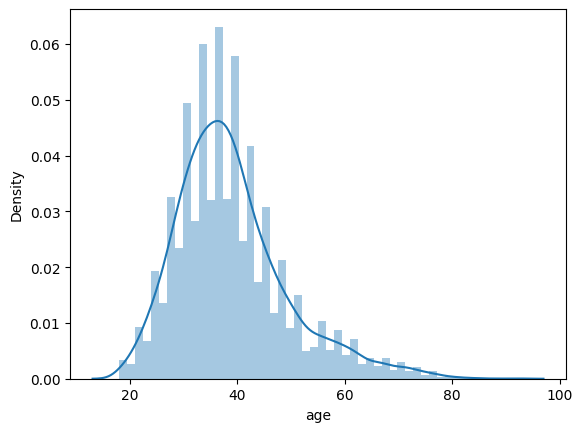

In [ ]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size= 0.2,random_state=42)

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

In [ ]:
#numeric & categorical preprocessing
numeric_trans = Pipeline(steps=[
    ('imputer',SimpleImputer(strategy='median')),
    ('scaler',StandardScaler())
])
categorical_trans = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])
preprocessor = ColumnTransformer(
    transformers=[
        ('nums',numeric_trans,num_cols),
        ('cat',categorical_trans,cat_cols)
    ]
)
print("✅ Preprocessing pipeline created")

✅ Preprocessing pipeline created


In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf_pipe = Pipeline(
    steps=[
        ('preprocessor',preprocessor),
        ('rf_clf',RandomForestClassifier(
            n_estimators=500,
            max_depth=10,
            class_weight='balanced',
            min_samples_split = 5,
            min_samples_leaf=2,
            random_state=42,
            n_jobs=-1
        ))
    ]
)
rf_pipe.fit(x_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('nums',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['credit_score', 'age',
                                                   'tenure', 'balance',
                                                   'products_number',
                                                   'credit_card',
                                                   'active_member',
                                                   'estimated_salary']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['country', 'gender'])])),
                ('rf_clf',
                 RandomForestClassifier(class_weight='balanced', max_depth=10,
                                        min_samples_leaf=2, min_samples_split=5,
                                        n_estimators=500, n_jobs=-1,
                                        random_state=42))])

In [ ]:
y_pred = rf_pipe.predict(x_test)

In [ ]:
from sklearn.metrics import classification_report
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.88      0.90      1607
           1       0.58      0.69      0.63       393

    accuracy                           0.84      2000
   macro avg       0.75      0.78      0.77      2000
weighted avg       0.85      0.84      0.85      2000



In [ ]:
y_proba = rf_pipe.predict_proba(x_test)[:, 1]


In [ ]:
from sklearn.metrics import roc_auc_score
print("ROC-AUC:", roc_auc_score(y_test, y_proba).round(4))

ROC-AUC: 0.8661


In [ ]:
feature_names = rf_pipe.named_steps['preprocessor'].get_feature_names_out()

# Extract importances
importances = rf_pipe.named_steps['rf_clf'].feature_importances_
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)

print(feat_imp.head(10))

nums__age                 0.318833
nums__products_number     0.204120
nums__balance             0.114952
nums__estimated_salary    0.079624
nums__credit_score        0.077904
nums__active_member       0.056378
nums__tenure              0.046645
cat__country_Germany      0.036396
cat__country_France       0.014962
cat__gender_Male          0.014755
dtype: float64


In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'rf_clf__n_estimators': [100, 200, 500],
    'rf_clf__max_depth': [None, 10, 20],
    'rf_clf__min_samples_split': [2, 5, 10],
    'rf_clf__min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(rf_pipe, param_grid,
                           scoring='roc_auc', cv=3, n_jobs=-1, verbose=2)

grid_search.fit(x_train, y_train)
print("Best Params:", grid_search.best_params_)
print("Best ROC-AUC:", grid_search.best_score_)


Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best Params: {'rf_clf__max_depth': 10, 'rf_clf__min_samples_leaf': 2, 'rf_clf__min_samples_split': 5, 'rf_clf__n_estimators': 500}
Best ROC-AUC: 0.8587910210138067


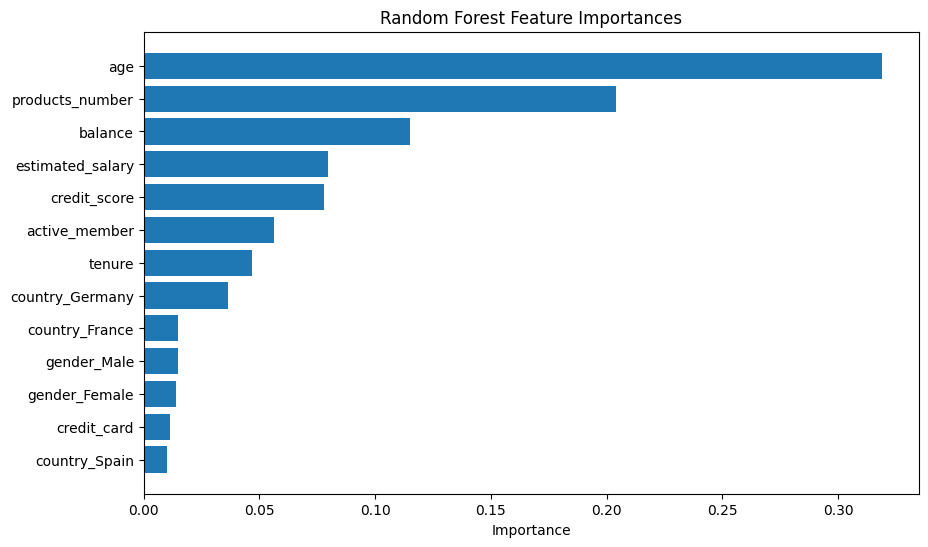

In [ ]:
import matplotlib.pyplot as plt

best_pipeline = grid_search.best_estimator_

# Get the trained Random Forest inside the pipeline
best_rf = best_pipeline.named_steps['rf_clf']

# Get feature names after preprocessing
cat_features = best_pipeline.named_steps['preprocessor'] \
    .named_transformers_['cat'] \
    .get_feature_names_out(['country', 'gender'])

all_features = np.concatenate([num_cols, cat_features])

# Feature importances
importances = best_rf.feature_importances_

# Put into DataFrame for sorting
feat_imp = pd.DataFrame({
    "Feature": all_features,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

# Plot
plt.figure(figsize=(10,6))
plt.barh(feat_imp["Feature"], feat_imp["Importance"])
plt.gca().invert_yaxis()  # highest at top
plt.title("Random Forest Feature Importances")
plt.xlabel("Importance")
plt.show()

In [ ]:
import joblib

joblib.dump(rf_pipe, "churn_model.pkl")


['churn_model.pkl']

ROC-AUC: 0.8661216592167537

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.88      0.90      1607
           1       0.58      0.69      0.63       393

    accuracy                           0.84      2000
   macro avg       0.75      0.78      0.77      2000
weighted avg       0.85      0.84      0.85      2000


Confusion Matrix:
 [[1414  193]
 [ 122  271]]


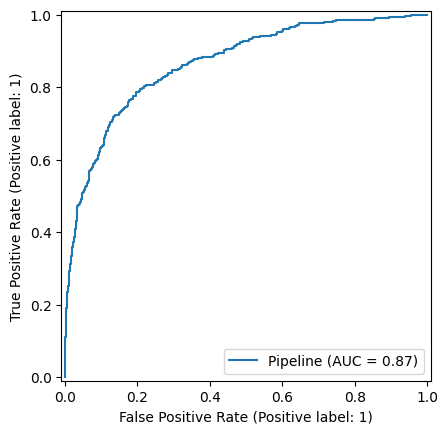

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay

y_pred = rf_pipe.predict(x_test)
y_proba = rf_pipe.predict_proba(x_test)[:,1]

print("ROC-AUC:", roc_auc_score(y_test, y_proba))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:\n", cm)

# Plot ROC
RocCurveDisplay.from_estimator(rf_pipe, x_test, y_test)


In [ ]:
#testing with random sample point
sample = pd.DataFrame([{
    "credit_score": 650,
    "country": "Spain",
    "gender": "Female",
    "age": 45,
    "tenure": 3,
    "balance": 50000,
    "products_number": 2,
    "credit_card": 1,
    "active_member": 1,
    "estimated_salary": 70000
}])

pred = rf_pipe.predict(sample)
proba = rf_pipe.predict_proba(sample)[:,1]

print("Churn Prediction:", "Yes" if pred[0]==1 else "No")
print("Churn Probability:", round(proba[0], 3))


Churn Prediction: No
Churn Probability: 0.357
